In [1]:
# Importing modules
import pandas as pd
from scripts.preprocessing import preprocess
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import joblib

In [2]:
# Data for training and validation
train_data = preprocess("data/train_set").spectra2df()

# Data for testing (Blind)
test_data = preprocess("data/test_set").spectra2df()

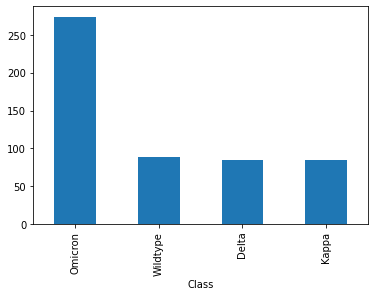

In [3]:
# Class distribution (Training and validation set)
train_data["Class"].value_counts().plot.bar()
plt.show()

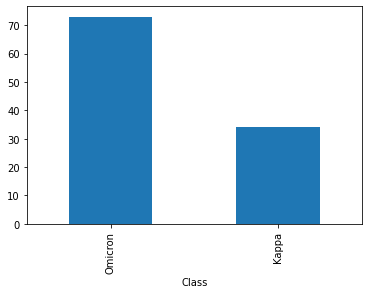

In [4]:
# Class distribution (Test/Blind set)
test_data["Class"].value_counts().plot.bar()
plt.show()

In [5]:
# Target labels
y = train_data["Class"]

# Feature matrix
X = train_data.drop(["Class", "Sample"], axis=1) 

# Training and validation split (80:20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Oversampling training set
oversampler = SMOTE(random_state=42)
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

# Scaling training and validation set
sds = StandardScaler()
scaled_X_train = pd.DataFrame(sds.fit_transform(X_train_os), columns=X_train_os.columns)
scaled_X_val = pd.DataFrame(sds.transform(X_val), columns=X_val.columns)
joblib.dump(sds, "models/scaler.pkl") # Saving scaler params

['models/scaler.pkl']

In [6]:
# Model 
classifier = SVC(random_state=42, probability=True)

# Best parameters found after hyperparameter tuning 
params = {"C": [10], "kernel": ["rbf"], "gamma": ["scale"]}

# Model training with 5 fold cv 
grid_search = GridSearchCV(classifier, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(scaled_X_train.to_numpy(), y_train_os)

# Final model
model = grid_search.best_estimator_

In [7]:
# Model Validation
y_pred_val = model.predict(scaled_X_val.to_numpy())

In [8]:
# Classification report (Validation set)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

       Delta       0.78      0.82      0.80        17
       Kappa       0.78      0.82      0.80        17
     Omicron       0.94      0.91      0.93        55
    Wildtype       0.94      0.94      0.94        18

    accuracy                           0.89       107
   macro avg       0.86      0.88      0.87       107
weighted avg       0.89      0.89      0.89       107



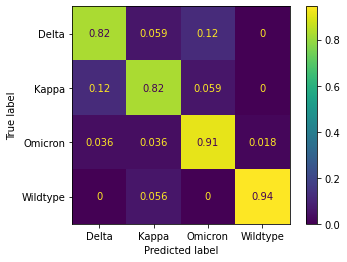

In [9]:
# Confusion matrix (Validation set)
cmat = confusion_matrix(y_val, y_pred_val, normalize="true")
disp_cmat = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=model.classes_)
disp_cmat.plot()
plt.show()

In [10]:
# Saving final SVM model
joblib.dump(model, "models/SVM_model.pkl")

['models/SVM_model.pkl']

In [11]:
# Target labels
y_test = test_data["Class"]

# Feature matrix
X_test = test_data.drop(["Class", "Sample"], axis=1)

# Scaling test set
sds = joblib.load("models/scaler.pkl") # Loading scaler params
scaled_X_test = pd.DataFrame(sds.transform(X_test), columns=X_test.columns)

In [12]:
# Loading SVM model
model = joblib.load("models/SVM_model.pkl")

# Model Testing (Evaluation on blind data)
y_pred_test = model.predict(scaled_X_test.to_numpy())

In [13]:
# Classification report (Test set)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       Delta       0.00      0.00      0.00         0
       Kappa       0.61      0.59      0.60        34
     Omicron       0.92      0.82      0.87        73
    Wildtype       0.00      0.00      0.00         0

    accuracy                           0.75       107
   macro avg       0.38      0.35      0.37       107
weighted avg       0.82      0.75      0.78       107



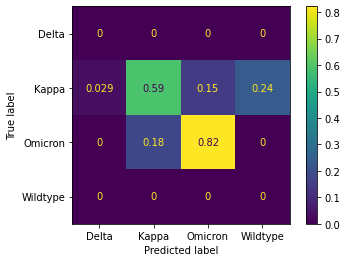

In [14]:
# Confusion matrix (Test set)
cmat = confusion_matrix(y_test, y_pred_test, normalize="true")
disp_cmat = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=model.classes_)
disp_cmat.plot()
plt.show()